In [1]:
import torchdata.datapipes as dp
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import numpy as np
import ot
import matplotlib.pyplot as plt
import timeit
import copy
from math import sqrt

from torch.autograd import grad as torch_grad


To cite:

J. M. C. Clark and R. J. Cameron. The maximum rate of convergence of discrete approximations for Stochastic differential equations. in Stochastic Differential Systems Filtering and Control, ed. by Grigelionis (Springer, Berlin), 1980.
A. S. Dickinson. Optimal Approximation of the Second Iterated Integral of Brownian Motion. Stochastic Analysis and Applications, 25(5):1109{1128, 2007.

F. Kastner, A. Rößler. "An Analysis of Approximation Algorithms for Iterated Stochastic Integrals and a Julia and Matlab Simulation Toolbox". arXiv:2201.08424

Foster, J. M. Numerical Approximations for Stochastic Differential Equations. University of Oxford, 2020.

In [2]:
device = torch.device('cpu')

noise_size = 62

# Number of training epochs using classical training
num_epochs = 20

# Number of iterations of Chen training
num_Chen_iters = 5000

# 'Adam' of 'RMSProp'
which_optimizer = 'Adam'

# Learning rate for optimizers
lrG = 0.00005
lrD = 0.0005

# Beta1 hyperparam for Adam optimizers
beta1 = 0

beta2 = 0.99

ngpu = 0

# To keep the criterion Lipschitz
weight_cliping_limit = 0.01

# for gradient penalty
gp_weight = 10.0

batch_size = 1024

test_batch_size = 16384

w_dim = 4

a_dim = int(w_dim*(w_dim - 1)//2)

s_dim = 1

# if 1 use GAN1, if 2 use GAN2, etc.
which_discriminator = 1
which_generator = 1
generator_symmetry_mode = "Hsym"
generator_last_width = a_dim
if generator_symmetry_mode == "sym":
    generator_last_width = a_dim + w_dim

if generator_symmetry_mode in ["Hsym", "sym"]:
    s_dim = int(2**w_dim)

# slope for LeakyReLU
leakyReLU_slope = 0.2

# this gives the option to rum the training process multiple times with differently initialised GANs
#num_trials = 1

num_tests_for2d = 8

In [3]:
# CHEN RELATION
# Levy-area satisfies a version of the Chen relation (see Chen_relation.pdf) and is the unique distribution which satisfies this version of the relation

def chen_combine(w_a_in: torch.Tensor):
    # the batch dimension of the inputs will be quartered
    out_size = w_a_in.shape[0]//2
    assert 2*out_size == w_a_in.shape[0]
    assert w_a_in.shape[1] == w_dim + a_dim

    # w_0_s is from 0 to t/2 and w_s_t is from t/2 to t
    w_0_s,w_s_t = w_a_in.chunk(2)
    result = torch.clone(w_0_s + w_s_t)
    result[:,:w_dim] = sqrt(0.5)*result[:,:w_dim]
    result[:,w_dim:(w_dim+a_dim)] = 0.5*result[:,w_dim:(w_dim+a_dim)]

    idx = w_dim
    for k in range(w_dim - 1):
        for l in range(k+1,w_dim):
            correction_term = 0.25*(w_0_s[:,k]*w_s_t[:,l] - w_0_s[:,l]*w_s_t[:,k])
            result[:,idx] += correction_term
            idx += 1

    return result


# prints the 2-Wasserstein distances (in each of the Levy-area dimensions) between the input and chen_combine(chen_combine(input))
# The idea behind this is that Levy-area is the unique distribution which is close to chen_combine of itself
# Indeed this is experimentally confirmed in test.ipynb

def chen_error_3step(w_a_in: torch.TensorType):
    combined_data = chen_combine(w_a_in)
    combined_data = chen_combine(combined_data)
    combined_data = chen_combine(combined_data)
    return [sqrt(ot.wasserstein_1d(combined_data[:,w_dim+i],w_a_in[:,w_dim+i],p=2)) for i in range(a_dim)]

# Calculate E[ A^2 | W ] = 1/12 * (1 + (W_1)^2 + (W_2)^2)

def true_second_moments(_w):
    _w_dim = len(_w)
    _w_squared = [x*x for x in _w]
    _a_dim = int((_w_dim - 1)*_w_dim/2)
    moms = []
    for k in range(_w_dim):
        for l in range(k+1,_w_dim):
            moms.append((1.0/12.0)*(1.0 + _w_squared[k] + _w_squared[l]))
    assert len(moms) == _a_dim
    return np.diag(moms)


def empirical_second_moments(_a_generated: np.ndarray):

    _batch_dim = _a_generated.shape[0]
    const = 1.0/_batch_dim
    _a_dim = _a_generated.shape[1]
    result = np.zeros((_a_dim,_a_dim))
    for i in range(_a_dim):
        for j in range(i, _a_dim):
            result[i,j] = const * np.dot(_a_generated[:,i], _a_generated[:,j])
            if i != j:
                result[j,i] = result[i,j]

    return result

def empirical_variances(_a_generated):
    return np.diagonal(empirical_second_moments(_a_generated))

# 2-Wasserstein distance between multidimensional distributions

def wass_dist(x1: torch.Tensor, x2: torch.Tensor):
    M = ot.dist(x1,x2, metric='sqeuclidean')
    return sqrt(ot.emd2([],[],M, numItermax=1000000))

def a_idx(i: int, j: int, _w_dim):
    if i == j:
        return None
    idx = 0
    for k in range(_w_dim):
        for l in range(k+1, _w_dim):
            if (i == k and j == l) or (j == k and i == l):
                return idx
            else:
                idx += 1

In [4]:
# SYMMETRY stuff
# calculate T and M

def generate_signs(n: int):
    lst = []
    for i in range(2**n):
        binary_exp = list(bin(i)[2:])
        lst.append((n-len(binary_exp))*[0]+binary_exp)

    res = 2*np.array(lst, dtype=float) - np.ones((2**n,n), dtype=float)
    return res

signs = generate_signs(w_dim)

first_dim = []
second_dim = []
third_dim = []
fourth_dim = []
values = []
M_list = []

for s in range(len(signs)):
    idx = 0
    M_row = []
    for i in range(w_dim):
        for j in range(i+1,w_dim):
            first_dim.append(s)
            second_dim.append(idx)
            third_dim.append(i)
            fourth_dim.append(j)
            values.append(-1*signs[s,j].item())
            first_dim.append(s)
            second_dim.append(idx)
            third_dim.append(j)
            fourth_dim.append(i)
            values.append(signs[s,j].item())
            idx+=1
            M_row.append(signs[s,j].item() * signs[s,i].item())
    M_list.append(M_row)

indices = [first_dim,second_dim,third_dim,fourth_dim]
T = torch.sparse_coo_tensor(indices=indices,values=values, size = (len(signs),a_dim,w_dim,w_dim)).to_dense().contiguous().detach()

M = torch.tensor(M_list).unsqueeze(1).contiguous().detach()


# A function that takes W, H and B (B is the Levy Area of the Brownian Bridge) and computes A = WTH+MB
# where the hell is maribor anyway?
def wthmb(w_in: torch.Tensor, h_in: torch.Tensor, b_in: torch.Tensor):
    _bsz = w_in.shape[0]
    assert w_in.shape == (_bsz,w_dim)
    assert h_in.shape == (_bsz, w_dim)
    assert b_in.shape == (_bsz, a_dim)
    _W = w_in.view(1,1,_bsz,w_dim)
    _H = h_in.view(_bsz,w_dim,1)
    _B = b_in.view(1,_bsz,a_dim)
    WT = torch.matmul(_W, T).permute(0,2,1,3)
    WTH = torch.matmul(WT, _H).squeeze()
    MB = torch.mul(M,_B)
    return torch.flatten(WTH + MB, start_dim=0,end_dim=1)

def wth(w_in: torch.Tensor, h_in: torch.Tensor):
    _bsz = w_in.shape[0]
    assert w_in.shape == (_bsz,w_dim)
    assert h_in.shape == (_bsz, w_dim)
    _W = w_in.view(1,1,_bsz,w_dim)
    _H = h_in.view(_bsz,w_dim,1)
    WT = torch.matmul(_W, T).permute(0,2,1,3)
    WTH = torch.flatten(torch.matmul(WT, _H).squeeze(), start_dim=0,end_dim=1).detach()
    return WTH

In [5]:
# create dataloader for samples

def row_processer(row):
    return torch.tensor(np.array(row, dtype=np.float32), dtype= torch.float, device= device)

filename = f"samples/samples_{w_dim}-dim.csv"
datapipe = dp.iter.FileOpener([filename], mode='t')
datapipe = datapipe.parse_csv(delimiter=',')
datapipe = datapipe.map(row_processer)
dataloader = DataLoader(dataset=datapipe, batch_size=batch_size, num_workers=2)

# Check if the dimensions match
d = next(iter(dataloader))
if d.size(1) != a_dim + w_dim:
    print("!!!!!!!!!!!!!!!!!!!!!!!!! WRONG DATA DIMENSIONS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

# print(d)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [7]:
# GAN 1

class Generator1(nn.Module):
    def __init__(self):
        super(Generator1, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(w_dim+noise_size,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128,generator_last_width)
        )

    def forward(self, input):
        noise, w = torch.split(input, [noise_size,w_dim], dim=1)
        if generator_symmetry_mode == "Hsym":
            bsz = input.shape[0]
            h = sqrt(1/12) * torch.randn((bsz,w_dim), dtype=torch.float)
            a = wth(w, h)
            x = torch.cat((noise,h),dim=1)
            b = self.main(x).view(1,bsz,a_dim)
            mb = torch.flatten(torch.mul(M, b), start_dim=0, end_dim=1)
            a += mb
            w = w.repeat((s_dim,1))
        elif generator_symmetry_mode == "sym":
            x = self.main(input)
            h = x[:,:w_dim]
            b = x[:,w_dim:w_dim+a_dim]
            a = wthmb(w,h,b)
            w = w.repeat((s_dim,1))
        else:
            a = self.main(input)

        return torch.cat((w,a), dim=1)


class Discriminator1(nn.Module):
    def __init__(self):
        super(Discriminator1, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(w_dim + a_dim,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(leakyReLU_slope),

            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(leakyReLU_slope),

            nn.Linear(512,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(leakyReLU_slope),

            nn.Linear(128,1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# GAN 2

class Generator2(nn.Module):
    def __init__(self):
        super(Generator2, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(w_dim+noise_size,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            # nn.Linear(1024,1024),
            # nn.BatchNorm1d(1024),
            # nn.ReLU(),

            nn.Linear(1024,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128,generator_last_width)
        )

    def forward(self, input):
        noise, w = torch.split(input, [noise_size,w_dim], dim=1)
        if generator_symmetry_mode == "Hsym":
            bsz = input.shape[0]
            h = sqrt(1/12) * torch.randn((bsz,w_dim), dtype=torch.float)
            a = wth(w, h)
            x = torch.cat((noise,h),dim=1)
            b = self.main(x).view(1,bsz,a_dim)
            mb = torch.flatten(torch.mul(M, b), start_dim=0, end_dim=1)
            a += mb
            w = w.repeat((s_dim,1))
        elif generator_symmetry_mode == "sym":
            x = self.main(input)
            h = x[:,:w_dim]
            b = x[:,w_dim:w_dim+a_dim]
            a = wthmb(w,h,b)
            w = w.repeat((s_dim,1))
        else:
            a = self.main(input)

        return torch.cat((w,a), dim=1)



class Discriminator2(nn.Module):
    def __init__(self):
        super(Discriminator2, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(w_dim + a_dim,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(leakyReLU_slope),

            nn.Linear(128,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(leakyReLU_slope),

            # nn.Linear(1024,1024),
            # nn.BatchNorm1d(1024),
            # nn.LeakyReLU(leakyReLU_slope),

            nn.Linear(1024,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(leakyReLU_slope),

            nn.Linear(128,1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# GAN 3

class Generator3(nn.Module):
    def __init__(self):
        super(Generator3, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(w_dim+noise_size,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128,generator_last_width)
        )

    def forward(self, input):
        noise, w = torch.split(input, [noise_size,w_dim], dim=1)
        if generator_symmetry_mode == "Hsym":
            bsz = input.shape[0]
            h = sqrt(1/12) * torch.randn((bsz,w_dim), dtype=torch.float)
            a = wth(w, h)
            x = torch.cat((noise,h),dim=1)
            b = self.main(x).view(1,bsz,a_dim)
            mb = torch.flatten(torch.mul(M, b), start_dim=0, end_dim=1)
            a += mb
            w = w.repeat((s_dim,1))
        elif generator_symmetry_mode == "sym":
            x = self.main(input)
            h = x[:,:w_dim]
            b = x[:,w_dim:w_dim+a_dim]
            a = wthmb(w,h,b)
            w = w.repeat((s_dim,1))
        else:
            a = self.main(input)

        return torch.cat((w,a), dim=1)


class Discriminator3(nn.Module):
    def __init__(self):
        super(Discriminator3, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(w_dim + a_dim,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(leakyReLU_slope),

            nn.Linear(512,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(leakyReLU_slope),

            nn.Linear(128,1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# initialize nets
if which_discriminator == 1:
    netD = Discriminator1().to(device)
elif which_discriminator == 2:
    netD = Discriminator2().to(device)
elif which_discriminator == 3:
    netD = Discriminator3().to(device)

if which_generator == 1:
    netG = Generator1().to(device)
elif which_generator == 2:
    netG = Generator2().to(device)
elif which_generator == 3:
    netG = Generator3().to(device)

netG.load_state_dict(torch.load(f'model_saves/GAN1_4d_62noise_min_sum_Hsymgenerator.pt'))
netD.load_state_dict(torch.load(f'model_saves/GAN1_4d_62noise_min_sum_discriminator.pt'))

# netD.apply(weights_init)
# netG.apply(weights_init)

<All keys matched successfully>

In [11]:
# Initialise optimiser

if which_optimizer == 'Adam':
    optG = torch.optim.Adam(netG.parameters(),lr = lrG, betas=(beta1,beta2))
    optD = torch.optim.Adam(netD.parameters(), lr = lrD, betas=(beta1, beta2))
elif which_optimizer == 'RMSProp':
    optG = torch.optim.RMSprop(netG.parameters(), lr = lrG)
    optD = torch.optim.RMSprop(netD.parameters(), lr = lrD)

# A fixed W increment for testing purposes
W_fixed_whole = [1.0,-0.5,-1.2,-0.3,0.7,0.2,-0.9,0.1,1.7]

W_fixed = torch.tensor(W_fixed_whole)[:w_dim].unsqueeze(1).transpose(1,0)
W_fixed = W_fixed.expand((test_batch_size,w_dim))

st_dev_W_fixed = np.sqrt(true_second_moments(W_fixed_whole[:w_dim]))

def avg_st_dev_error(_a_generated):
    difference = np.abs(st_dev_W_fixed - np.sqrt(np.abs(empirical_second_moments(_a_generated))))
    return difference.mean()


# Load "true" samples generated from this fixed W increment
test_filename = f"samples/fixed_samples_{w_dim}-dim.csv"
A_fixed_true = np.genfromtxt(test_filename,dtype=float,delimiter=',',)
A_fixed_true = A_fixed_true[:test_batch_size,w_dim:(w_dim+a_dim)]

wass_errors = []
chen_errors = []

iters = 0

one = torch.FloatTensor([1])
mone = one * -1

# testing data for w_dim = 2
fixed_data = [np.genfromtxt(f"samples/fixed_samples_2-dim{i+1}.csv",dtype=float,delimiter=',') for i in range(num_tests_for2d)]


def all_2dim_errors(_netG):
    assert w_dim == 2
    errs = []
    for i in range(num_tests_for2d):
        # Test Wasserstein error for fixed W
        data_fixed_true = fixed_data[i]
        A_fixed_true = data_fixed_true[:,2]
        W_combo = torch.tensor(data_fixed_true[:,:2], dtype= torch.float)
        noise = torch.randn((test_batch_size,noise_size), dtype=torch.float, device=device)
        g_in = torch.cat((noise,W_combo),1)
        A_fixed_gen = _netG(g_in)[:,3].detach().numpy().squeeze()
        errs.append(sqrt(ot.wasserstein_1d(A_fixed_true,A_fixed_gen,p=2)))

    return errs

In [12]:
def _gradient_penalty(real_data, generated_data):
    b_size_gp = real_data.size()[0]

    # Calculate interpolation
    alpha = torch.rand(b_size_gp, 1)
    alpha = alpha.expand_as(real_data)
    interpolated = (alpha * real_data.data + (1 - alpha) * generated_data.data).requires_grad_(True)

    if ngpu > 0:
        interpolated = interpolated.cuda()

    # Calculate probability of interpolated examples
    prob_interpolated = netD(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(prob_interpolated.size()).cuda() if ngpu > 0 else torch.ones(
                           prob_interpolated.size()),
                           create_graph=True, retain_graph=True)[0]

    # Gradients have shape (b_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(b_size_gp, -1)
    # grad_norm = gradients.norm(2, dim=1).mean().item()

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
    avg_grad_norm = gradients_norm.mean().item()

    # Return gradient penalty
    return (gp_weight * ((gradients_norm - 1) ** 2).mean(), avg_grad_norm)

In [13]:
# Early stopping setup

# Will have two backup points:
# One where the sum of Wasserstein errors was minimal and one where the max was minimal

min_sum = float('inf')
min_sum_errors = [1.0 for i in range(a_dim)]
min_sum_paramsG = copy.deepcopy(netG.state_dict())
min_sum_paramsD = copy.deepcopy(netD.state_dict())

min_chen_err_sum = float('inf')
min_chen_errors = [1.0 for i in range(a_dim)]
min_chen_paramsG = copy.deepcopy(netG.state_dict())
min_chen_paramsD = copy.deepcopy(netD.state_dict())

In [ ]:
for epoch in range(num_epochs):

    for i, data in enumerate(dataloader):
        netD.zero_grad()
        netG.zero_grad()

        # weight clipping so critic is lipschitz
        # for p in netD.parameters():
        #     p.data.clamp_(-weight_cliping_limit, weight_cliping_limit)

        # check actual batch size (last batch could be shorter)
        b_size = data.size(0)

        noise = torch.randn((b_size,noise_size), dtype=torch.float, device=device)
        w = data[:,:w_dim]
        z = torch.cat((noise,w), dim=1)
        fake_data = netG(z)
        fake_data = fake_data.detach()
        pruning_indices = torch.randperm(b_size*s_dim)[:b_size]
        pruned_fake_data = fake_data[pruning_indices]

        gradient_penalty, gradient_norm = _gradient_penalty(data,pruned_fake_data)

        prob_real = netD(data)

        prob_fake = netD(fake_data)

        lossD_fake = prob_fake.mean(0).view(1)
        lossD_real = prob_real.mean(0).view(1)
        lossD = lossD_fake - s_dim*lossD_real + gradient_penalty
        lossD.backward()
        optD.step()

        # train Generator with probability 1/5
        if iters%5 == 0:
            netG.zero_grad()
            noise = torch.randn((b_size,noise_size), dtype=torch.float, device=device)
            w = data[:,:w_dim]
            z = torch.cat((noise,w), dim=1)
            fake_data = netG(z)
            lossG = netD(fake_data)
            lossG = - lossG.mean(0).view(1)
            lossG.backward()
            optG.step()

        if iters%100 == 0:

            # Test Chen discrepancy
            W = torch.randn((4*batch_size, w_dim), dtype= torch.float, device=device)
            noise = torch.randn((4*batch_size,noise_size), dtype=torch.float, device=device)
            gen_in = torch.cat((noise,W),1)
            generated_data = netG(gen_in).detach()
            ch_err = chen_error_3step(generated_data)
            pretty_chen_errors = ["{0:0.5f}".format(i) for i in ch_err]


            report = ""

            # Test Wasserstein error for fixed W
            if w_dim > 2:
                noise = torch.randn((test_batch_size,noise_size), dtype=torch.float, device=device)
                g_in = torch.cat((noise,W_fixed),1)
                A_fixed_gen = netG(g_in)[:,w_dim:w_dim+a_dim].detach().numpy()
                #Compute various distances between "true" data and generated data
                joint_wass_dist = 0.0
                #joint_wass_dist = wass_dist(A_fixed_true[:1000],A_fixed_gen[:1000])
                errors = [sqrt(ot.wasserstein_1d(A_fixed_true[:,i],A_fixed_gen[:,i],p=2)) for i in range(a_dim)]
                pretty_errors = ["{0:0.5f}".format(i) for i in errors]
                st_dev_err = avg_st_dev_error(A_fixed_gen)

                report = f"epoch: {epoch}/{num_epochs}, iter: {iters}, gradient norm: {gradient_norm:.4f}, st_dev error: {st_dev_err: .4f} discriminator dist: {(lossD_fake - lossD_real).item():.7f}, joint_wass_dist: {joint_wass_dist: .5f} \n individual errors {pretty_errors}, ch_err: {pretty_chen_errors}"
            else:
                # slightly different report if working in only 2 dimensions
                errors = all_2dim_errors(netG)
                pretty_errors = ["{0:0.5f}".format(i) for i in errors]
                report = f"epoch: {epoch}/{num_epochs}, iter: {iters}, gradient norm: {gradient_norm}, discriminator dist: {(lossD_fake - lossD_real).item()} \n errors: {pretty_errors}, ch_err: {pretty_chen_errors[0]}"

            # Print out partial results

            print(report)
            # Save for plotting
            wass_errors.append(errors)
            chen_errors.append(ch_err)

            # Early stopping checkpoint
            error_sum = sum(errors)
            if error_sum <= min_sum:
                min_sum = error_sum
                min_sum_errors = errors
                min_sum_paramsG = copy.deepcopy(netG.state_dict())
                min_sum_paramsD = copy.deepcopy(netD.state_dict())
                print("Saved parameters (fixed error)")

            # if iters == 1000:
            #     torch.save(copy.deepcopy(netD.state_dict()), f'model_saves/GAN{which_model}_{w_dim}d_1000iter_discriminator.pt')

            chen_err_sum = sum(ch_err)
            if chen_err_sum < min_chen_err_sum:
                min_chen_err_sum = chen_err_sum
                min_chen_errors = ch_err
                min_chen_paramsG = copy.deepcopy(netG.state_dict())
                min_chen_paramsD = copy.deepcopy(netD.state_dict())
                print("Saved parameters (chen errors)")

        iters += 1

/home/andy/anaconda3/envs/GAN/lib/python3.10/site-packages/ot/lp/solver_1d.py:41: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484746364/work/aten/src/ATen/native/TensorShape.cpp:2981.)
  cws = cws.T.contiguous()


epoch: 0/20, iter: 0, gradient norm: 0.5066, st_dev error:  0.0577 discriminator dist: -0.0110216, joint_wass_dist:  0.00000 
 individual errors ['0.06422', '0.03282', '0.04746', '0.05102', '0.04299', '0.03562'], ch_err: ['0.54399', '0.52651', '0.13352', '0.55351', '0.12161', '0.12407']
Saved parameters (fixed error)
Saved parameters (chen errors)
epoch: 0/20, iter: 100, gradient norm: 0.6336, st_dev error:  0.0589 discriminator dist: -0.0103763, joint_wass_dist:  0.00000 
 individual errors ['0.05027', '0.03808', '0.15637', '0.03327', '0.03024', '0.02818'], ch_err: ['0.54094', '0.47203', '0.22674', '0.50037', '0.09445', '0.10041']
Saved parameters (chen errors)
epoch: 0/20, iter: 200, gradient norm: 0.8069, st_dev error:  0.0593 discriminator dist: -0.0182093, joint_wass_dist:  0.00000 
 individual errors ['0.06017', '0.04116', '0.06515', '0.04197', '0.04968', '0.04396'], ch_err: ['0.55689', '0.46353', '0.15151', '0.47793', '0.07593', '0.06842']
Saved parameters (chen errors)
epoch: 0

In [15]:

paramsD = copy.deepcopy(netD.state_dict())
torch.save(min_sum_paramsD, f'model_saves/GAN{which_discriminator}_{w_dim}d_{noise_size}noise_min_sum_discriminator.pt')
paramsG = copy.deepcopy(netG.state_dict())
torch.save(min_sum_paramsG, f'model_saves/GAN{which_generator}_{w_dim}d_{noise_size}noise_min_sum_{generator_symmetry_mode}generator.pt')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


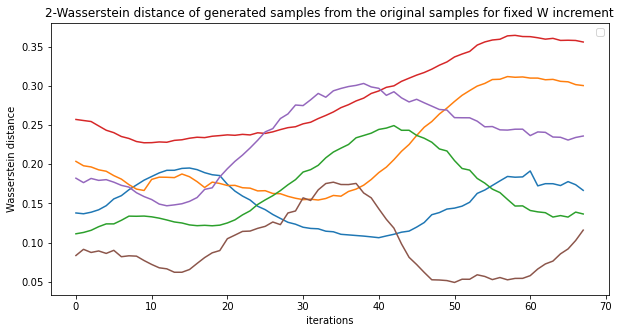

In [64]:
# Draw errors through iterations

plt.figure(figsize=(10,5))
plt.title("2-Wasserstein distance of generated samples from the original samples for fixed W increment")
plt.plot(wass_errors)
plt.xlabel("iterations")
plt.ylabel("Wasserstein distance")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


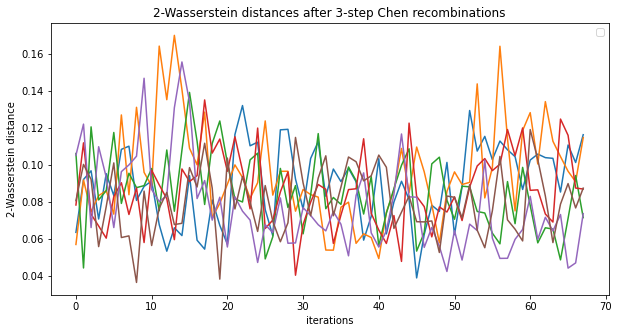

In [65]:
plt.figure(figsize=(10,5))
plt.title("2-Wasserstein distances after 3-step Chen recombinations")
plt.plot(chen_errors)
plt.xlabel("iterations")
plt.ylabel("2-Wasserstein distance")
plt.legend()
plt.show()

In [14]:
noise = torch.randn((test_batch_size,noise_size), dtype=torch.float, device=device)
g_in = torch.cat((noise,W_fixed),1)
A_fixed_gen = netG(g_in).detach()
for o in A_fixed_gen:
    print(o)

tensor([0.0778])
tensor([0.4096])
tensor([0.1468])
tensor([-0.4029])
tensor([0.3672])
tensor([0.7254])
tensor([0.9852])
tensor([-0.2910])
tensor([0.2513])
tensor([-0.0840])
tensor([0.0736])
tensor([0.2982])
tensor([0.5212])
tensor([-0.0252])
tensor([0.3866])
tensor([0.1867])
tensor([0.6774])
tensor([0.5489])
tensor([0.3787])
tensor([-0.9087])
tensor([0.4508])
tensor([-1.5749])
tensor([0.1448])
tensor([0.3202])
tensor([0.0525])
tensor([0.3915])
tensor([0.3669])
tensor([-0.6048])
tensor([0.2707])
tensor([0.1970])
tensor([0.1764])
tensor([1.0402])
tensor([0.3440])
tensor([0.1170])
tensor([0.0159])
tensor([-0.3987])
tensor([0.3408])
tensor([0.3106])
tensor([0.8292])
tensor([0.7913])
tensor([0.2034])
tensor([0.3189])
tensor([0.0853])
tensor([0.0857])
tensor([0.2336])
tensor([-0.0222])
tensor([-0.1752])
tensor([0.3368])
tensor([0.0657])
tensor([-0.2178])
tensor([-1.3557])
tensor([-0.4487])
tensor([0.2781])
tensor([-0.0260])
tensor([0.2359])
tensor([0.3060])
tensor([0.2718])
tensor([0.2906])


W_fixed = [1.0,-0.5,-1.2,-0.3,0.7,0.2,-0.9,0.1,1.7]
list_pairs(5) = [(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]

GAN2 best: ['0.06348', '0.25953', '0.06187', '0.11594', '0.12005', '0.11992', '0.07918', '0.15956', '0.16242', '0.01383']

In [14]:
# Return to early stopping checkpoint
if which_generator == 1:
    best_netG = Generator1().to(device)
elif which_generator == 2:
    best_netG = Generator2().to(device)
elif which_generator == 3:
    best_netG = Generator3().to(device)



best_netG.load_state_dict(min_sum_paramsG)

errors = all_2dim_errors(best_netG)
pretty_errors = ["{0:0.5f}".format(i) for i in errors]
print(f"errors: {pretty_errors}")


paramsG = copy.deepcopy(netG.state_dict())
paramsD = copy.deepcopy(netD.state_dict())

torch.save(paramsG, f'model_saves/GAN{which_generator}_{w_dim}d_{noise_size}noise_{num_epochs}epoch_generator.pt')
torch.save(paramsD, f'model_saves/GAN{which_discriminator}_{w_dim}d_{noise_size}noise_{num_epochs}epoch_discriminator.pt')
# best_netD = Discriminator()
# best_netD.load_state_dict(min_sum_paramsD)

errors: ['0.05340', '0.07916', '0.06400', '0.04085', '0.06473', '0.03897', '0.06568', '0.17557']


In [ ]:
# Test Wasserstein error for fixed W
noise = torch.randn((test_batch_size,noise_size), dtype=torch.float, device=device)
g_in = torch.cat((noise,W_fixed),1)
A_fixed_gen = best_netG(g_in).detach().numpy()
errors = [sqrt(ot.wasserstein_1d(A_fixed_true[:,i],A_fixed_gen[:,i],p=2)) for i in range(a_dim)]

# Print out partial results
pretty_errors = ["{0:0.5f}".format(i) for i in errors]
print(f"best net errors: {pretty_errors}")

best net errors: ['0.06348', '0.25953', '0.06187', '0.11594', '0.12005', '0.11992', '0.07918', '0.15956', '0.16242', '0.01383']

In [ ]:
chen_iters = 0
chen_training_wass_errors = []
chen_training_chen_errors = []
for i in range(num_Chen_iters):
    netD.zero_grad()

    # weight clipping so critic is lipschitz
    for p in netD.parameters():
        p.data.clamp_(-weight_cliping_limit, weight_cliping_limit)

    # Train Discriminator
    # generate 4*batch_size of fake data
    W = torch.randn((4*batch_size, w_dim), dtype= torch.float, device=device)
    noise = torch.randn((4*batch_size,noise_size), dtype=torch.float, device=device)
    gen_in = torch.cat((noise,W),1)
    A_gen = netG(gen_in)
    fake_in = torch.cat((W,A_gen.detach()),1)
    lossD_fake = netD(fake_in)
    lossD_fake = lossD_fake.mean(0).view(1)
    lossD_fake.backward(mone)

    # now use chen_combine to produce "true" data from the fake one
    # using chen_combine twice reduces batch dimension from 4*batch_size to batch_size
    true_data = chen_combine(fake_in.detach())
    true_data = chen_combine(true_data)
    true_data = chen_combine(true_data)
    assert true_data.size(0) == batch_size//2

    lossD_real = netD(true_data)
    lossD_real = 8 * lossD_real.mean(0).view(1) # multiply by 4 to counteract the 4x smaller batch
    lossD_real.backward(one)
    optD.step()

    # train Generator with probability 1/5
    # if np.random.randint(1,6) == 5:
    if True:
        netG.zero_grad()

        fake_in = torch.cat((W,A_gen),1)
        lossG = netD(fake_in)
        lossG = lossG.mean(0).view(1)
        lossG.backward(one)
        optG.step()

    if chen_iters%100 == 0:
        # Test Wasserstein error for fixed W
        noise = torch.randn((test_batch_size,noise_size), dtype=torch.float, device=device)
        g_in = torch.cat((noise,W_fixed),1)
        A_fixed_gen = netG(g_in).detach().numpy()
        errors = [sqrt(ot.wasserstein_1d(A_fixed_true[:,i],A_fixed_gen[:,i],p=2)) for i in range(a_dim)]
        chen_training_wass_errors.append(errors)

        # Test Chen discrepancy
        W = torch.randn((4*batch_size, w_dim), dtype= torch.float, device=device)
        noise = torch.randn((4*batch_size,noise_size), dtype=torch.float, device=device)
        gen_in = torch.cat((noise,W),1)
        A_gen = netG(gen_in)
        w_a = torch.cat((W,A_gen.detach()),1)
        ch_err = chen_error_3step(w_a)

        # Print out partial results
        pretty_errors = ["{0:0.5f}".format(i) for i in errors]
        pretty_chen_errors = ["{0:0.5f}".format(i) for i in ch_err]
        print(f"iter: {chen_iters}/{num_Chen_iters},\n errors: {pretty_errors}, \n chen errors: {pretty_chen_errors}")
        # Save for plotting
        chen_training_wass_errors.append(errors)
        chen_training_chen_errors.append(ch_err)


        # Early stopping checkpoint
        error_sum = sum(errors)
        if error_sum <= min_sum:
            min_sum = error_sum
            min_sum_errors = errors
            min_sum_paramsG = copy.deepcopy(netG.state_dict())
            min_sum_paramsD = copy.deepcopy(netD.state_dict())
            print("Saved parameters")

    chen_iters += 1

In [ ]:
# Draw errors through iterations

plt.figure(figsize=(10,5))
plt.title("2-Wasserstein distance of generated samples from the original samples for fixed W increment")
plt.plot(chen_training_wass_errors)
plt.xlabel("iterations")
plt.ylabel("Wasserstein distance")
plt.legend()
plt.show()

In [ ]:
# Time measurements

W_fixed: torch.Tensor = torch.tensor([1.0,-0.5,-1.2,-0.3,0.7,0.2,-0.9,0.1,1.7])
W_fixed = W_fixed[:w_dim].unsqueeze(1).transpose(1,0)
W_fixed = W_fixed.expand((test_batch_size,w_dim))
noise = torch.randn((test_batch_size,noise_size), dtype=torch.float, device=device)
g_in = torch.cat((noise,W_fixed),1)
netG.eval()
start_time = timeit.default_timer()
for i in range(100):
    A_fixed_out=netG(g_in)

elapsed = timeit.default_timer() - start_time
print(elapsed)

Takes 34.2s to generate 6553600 samples (original GAN)
Calling iterated_integrals(h = 1.0, err = 0.0005) 6553600-times takes 100.5s